In [71]:
import tensorflow as tf
import numpy as np
import matplotlib
import os
import pandas as pd
import matplotlib.pyplot as plt

tf.set_random_seed(777)  # reproducibility
# tensorflow init 
tf.reset_default_graph()

In [72]:
if "DISPLAY" not in os.environ:
    # remove Travis CI Error
    matplotlib.use('Agg')


In [73]:
data = pd.read_excel('조비수정.xlsx')

In [74]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)

In [75]:
# train Parameters
seq_length = 90
data_dim = 43
hidden_dim = 5
output_dim = 1
learning_rate = 0.005
iterations = 5000


In [76]:
# Open, High, Low, Volume, Close
# xy = np.loadtxt('data-02-stock_daily.csv', delimiter=',')
# xy = xy[::-1]  # reverse order (chronically ordered)
# print(np.shape(xy))
# data = pd.read_excel('stock.xlsx')
data = pd.read_excel('조비수정.xlsx')

In [77]:
data2 = data
# test = data.ix[:,:10]  열수정하는 방법
# xy = np.dstack([data2[1],data2[2],data2[3],data2[4],data2[5],data2[6],data2[7],data2[8],data2[9],data2[10],data2[11],data2[12],data2[13],data2[14],data2[15],data2[16],data2[17],data2[18],data2[19],data2[20],data2[21],data2[22],data2[23],data2[24],data2[25],data2[26],data2[27],data2[28],data2[29],data2[30],data2[31],data2[32],data2[33],data2[34],data2[35],data2[36],data2[37],data2[38],data2[39],data2[40],data2[41],data2[42],data2[43]])
xy = np.array(data2)
xy = xy.reshape(-1,data_dim)


xy = MinMaxScaler(xy)
x = xy
y = xy[:, [0]]  # Close as label

In [78]:
y[0]

array([0.09791036])

In [79]:
# build a dataset
dataX = []
dataY = []
for i in range(0, len(y) - seq_length):
    _x = x[i:i + seq_length]
    _y = y[i + seq_length]  # Next close price
#     print(_x, "->", _y)
    dataX.append(_x)
    dataY.append(_y)


In [80]:
# train/test split 
train_size = int(len(dataY) * 0.99)
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(
    dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[0:train_size]), np.array(
    dataY[train_size:len(dataY)])

In [81]:
# input place holders
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

In [82]:

# build a LSTM network
cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)

outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

Y_pred = tf.contrib.layers.fully_connected(
    outputs[:, -1], output_dim, activation_fn=None)  # We use the last cell's output


In [83]:
# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

In [84]:
# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

In [ ]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        if i% 200 == 0:
            print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    # Plot predictions
    plt.plot(testY,label="v")
    plt.plot(test_predict,label="p")
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

[step: 0] loss: 824.7437133789062
[step: 1] loss: 474.87493896484375
[step: 2] loss: 294.2059326171875
[step: 3] loss: 226.38458251953125
[step: 4] loss: 207.13803100585938
[step: 5] loss: 195.65997314453125
[step: 6] loss: 177.76121520996094
[step: 7] loss: 153.31101989746094
[step: 8] loss: 126.53548431396484
[step: 9] loss: 101.78870391845703
[step: 10] loss: 82.14453125
[step: 11] loss: 69.01417541503906
[step: 12] loss: 62.137203216552734
[step: 13] loss: 59.880836486816406
[step: 14] loss: 59.872154235839844
[step: 15] loss: 59.81163024902344
[step: 16] loss: 58.162193298339844
[step: 17] loss: 54.43437194824219
[step: 18] loss: 49.04769515991211
[step: 19] loss: 42.9533805847168
[step: 20] loss: 37.21433639526367
[step: 21] loss: 32.670188903808594
[step: 22] loss: 29.751562118530273
[step: 23] loss: 28.448959350585938
[step: 24] loss: 28.400463104248047
[step: 25] loss: 29.046091079711914
[step: 26] loss: 29.800336837768555
[step: 27] loss: 30.20136833190918
[step: 28] loss: 30

[step: 229] loss: 3.3856592178344727
[step: 230] loss: 3.376845598220825
[step: 231] loss: 3.36812424659729
[step: 232] loss: 3.359494924545288
[step: 233] loss: 3.350954532623291
[step: 234] loss: 3.342499017715454
[step: 235] loss: 3.3341355323791504
[step: 236] loss: 3.3258562088012695
[step: 237] loss: 3.317659854888916
[step: 238] loss: 3.3095459938049316
[step: 239] loss: 3.3015120029449463
[step: 240] loss: 3.293564796447754
[step: 241] loss: 3.2856855392456055
[step: 242] loss: 3.2778890132904053
[step: 243] loss: 3.270165205001831
[step: 244] loss: 3.2625155448913574
[step: 245] loss: 3.254941701889038
[step: 246] loss: 3.247439384460449
[step: 247] loss: 3.240003824234009
[step: 248] loss: 3.2326436042785645
[step: 249] loss: 3.2253458499908447
[step: 250] loss: 3.218116044998169
[step: 251] loss: 3.210953950881958
[step: 252] loss: 3.2038583755493164
[step: 253] loss: 3.1968226432800293
[step: 254] loss: 3.189849376678467
[step: 255] loss: 3.182943105697632
[step: 256] loss:

[step: 454] loss: 2.335723638534546
[step: 455] loss: 2.3325986862182617
[step: 456] loss: 2.3294782638549805
[step: 457] loss: 2.3263680934906006
[step: 458] loss: 2.3232619762420654
[step: 459] loss: 2.3201615810394287
[step: 460] loss: 2.3170671463012695
[step: 461] loss: 2.3139829635620117
[step: 462] loss: 2.310903787612915
[step: 463] loss: 2.3078255653381348
[step: 464] loss: 2.3047537803649902
[step: 465] loss: 2.301692008972168
[step: 466] loss: 2.2986340522766113
[step: 467] loss: 2.295583486557007
[step: 468] loss: 2.292539596557617
[step: 469] loss: 2.2894976139068604
[step: 470] loss: 2.286466121673584
[step: 471] loss: 2.2834393978118896
[step: 472] loss: 2.2804155349731445
[step: 473] loss: 2.2773995399475098
[step: 474] loss: 2.2743916511535645
[step: 475] loss: 2.271385669708252
[step: 476] loss: 2.2683887481689453
[step: 477] loss: 2.265397071838379
[step: 478] loss: 2.2624104022979736
[step: 479] loss: 2.259431838989258
[step: 480] loss: 2.2564563751220703
[step: 481

[step: 678] loss: 1.7962454557418823
[step: 679] loss: 1.7945902347564697
[step: 680] loss: 1.7929418087005615
[step: 681] loss: 1.7912983894348145
[step: 682] loss: 1.7896608114242554
[step: 683] loss: 1.7880282402038574
[step: 684] loss: 1.7864012718200684
[step: 685] loss: 1.7847820520401
[step: 686] loss: 1.7831648588180542
[step: 687] loss: 1.7815552949905396
[step: 688] loss: 1.779950499534607
[step: 689] loss: 1.7783503532409668
[step: 690] loss: 1.7767560482025146
[step: 691] loss: 1.7751667499542236
[step: 692] loss: 1.7735824584960938
[step: 693] loss: 1.7720038890838623
[step: 694] loss: 1.7704309225082397
[step: 695] loss: 1.7688629627227783
[step: 696] loss: 1.7672994136810303
[step: 697] loss: 1.7657413482666016
[step: 698] loss: 1.7641876935958862
[step: 699] loss: 1.7626394033432007
[step: 700] loss: 1.7610973119735718
[step: 701] loss: 1.7595574855804443
[step: 702] loss: 1.7580242156982422
[step: 703] loss: 1.7564966678619385
[step: 704] loss: 1.7549725770950317
[step

[step: 901] loss: 1.5209310054779053
[step: 902] loss: 1.5199832916259766
[step: 903] loss: 1.519040584564209
[step: 904] loss: 1.5180997848510742
[step: 905] loss: 1.5171594619750977
[step: 906] loss: 1.5162229537963867
[step: 907] loss: 1.515285849571228
[step: 908] loss: 1.5143535137176514
[step: 909] loss: 1.5134197473526
[step: 910] loss: 1.5124905109405518
[step: 911] loss: 1.5115630626678467
[step: 912] loss: 1.5106356143951416
[step: 913] loss: 1.5097098350524902
[step: 914] loss: 1.5087870359420776
[step: 915] loss: 1.507866621017456
[step: 916] loss: 1.5069469213485718
[step: 917] loss: 1.5060300827026367
[step: 918] loss: 1.5051134824752808
[step: 919] loss: 1.5042002201080322
[step: 920] loss: 1.503287672996521
[step: 921] loss: 1.502377986907959
[step: 922] loss: 1.5014703273773193
[step: 923] loss: 1.500562071800232
[step: 924] loss: 1.4996575117111206
[step: 925] loss: 1.4987540245056152
[step: 926] loss: 1.4978522062301636
[step: 927] loss: 1.4969515800476074
[step: 928

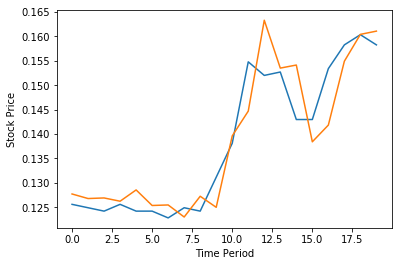

In [60]:
plt.plot(testY[20:40],label="v")
plt.plot(test_predict[20:40],label="p")
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.show()